# ADAvengers: Pints & Politics - Sipping Through Red, Blue, and Brew in U.S.  

In the light of recent elections and the present passion for beer in American culture, we embark on a unique journey to uncover link between politics and pints. Our analysis delves into the heart of the American lifestyle, exploring whether the beers we sip reveal more than just our taste preferences, perhaps even our political leanings!  

We will explore [BeerAdvocate](https://www.beeradvocate.com/) dataset which provides information about beers, breweries, users and their ratings. Dataset contains over 2 million reviews coming from U.S. users We find that this information is sufficient to conduct our analysis, leading us to focusing solely on the BeerAdvocate dataset. The reviews in the dataset span over years from 2001 to 2017. For our analysis particularly, data coming from `users.csv` (which provides information on location of user) and `reviews.txt`.  

We gathered political information from several different sources. For our analysis we required information about the winning parties in each U.S. state, in the election years 2004-2016, obtained from [U.S. President 1976-2020](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX). To get more fine-grained data on age-specific voting preferences we used exit polls found on various different sources. The information was available for the mentioned election years, however not for all the states. This is due to the fact that exit polls are of interest in states that change their political climate over the years, swing states. Since conducting these surveys is costly, the consistently Democrat or Republican states are usually omitted.

**Note:** This Notebook contains frequent usage of interactive plots. This is due to the fact that problem we are discusing has mutiple dimensions - states, years, beer styles, ratings, sentiment, so it is more comprehensible for analyzing and reviewing when one can select/filter out displayed content. 

In [18]:
import plotly.graph_objects as go 
import plotly.express as px
from pathlib import Path
from dash import Dash, dcc, html 
from dash.dependencies import Input, Output
from scipy.stats import pearsonr, spearmanr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

import sys
import os
data_path = os.path.abspath('./src/data/')
sys.path.append(data_path)

utils_path = os.path.abspath('./src/plots/')
sys.path.append(utils_path)

import plot_state_map
import correlations as corr
import reviews_processing
import load_and_find_party_winners
import favourite_beers_processing
import plotting_utils

In [2]:
%load_ext autoreload
%autoreload 2

## Pipeline for the analysis  

- Understanding the beer reviews and initial analysis
- Dive into political data
- Clustering of voting trends and look-alike analysis
- Comparison of beer trends between look-alike states
- Is swing pattern in states somehow noticable in beer preferences?

## What's behind beer reviews?  

As we stated, we mainly focused on `reviews.txt` file to extract all the necessary information for our analysis. This file first needed exhaustive parsing to be converted into .csv. Code for producing it can be found in `/src/data/load_and_parse_beeradvocate_reviews.py`. For further analysis we used parsed `reviews_df.csv`.  

Some preprocessing steps were needed for our dataset on presidental elections too. It initially containing number of votes each party candidate won in the specific years for a specific state. We converted those numbers into percentages and identified winning party as the one which won maximum percentage in each year for each state. This file is on our project's GitHub under `/data/generated/party_winners_over_years.csv` and is generated by script `/src/data/load_and_find_party_winners.py`.  

In the following cell, we further process the `reviews_df.csv`. Namely in the *first step*, we merged it with `users.csv` to extract the information about the location of the user, i.e. where are they coming from, focusing solely on users coming from United States. After this first step of filtering we are left out with over 2 million reviews.  

*Second step* is to aggregate beer styles in more general categories. By looking into the data we notice that there is 104 unique beer styles among reviewed beers which is a lot to analyze. Therefore, we hopped on a quick internet search to understand what are the most popular and common beer categories. Through this we identified: IPAs, Ales, Stouts, Porters, Lagers, Pilsners. Since Ales category contained many different subcategories with different properties (and also a lot of different reviews in our dataset), we opted to split it in Pale Ales, Red/Amber Ales and Other Ales - leaving us with total of 8 high-level beer categories. By keyword matching, we managed to assign beer styles into our 8 categories. Out of initial 104 unique beer styles, we were left with 56, accounting for 75% of total beer reviews.  

*Finally*, we need to choose a meta-level aggreagation metric on which we will analyze preference between categorized beer styles (referred as simply beer styles in the later text and plots). For this purpose, we chose **average rating** calculated as mean of 5 aspects that beer reviewers' rate on BeerAdvocate website - palate, aroma, taste, appearance and overall. We opted for this one as we believed that it captures the best overall impression of the reviewer with the specific beer. Therefore, for every state, year, beer style combination we calculated mean of average ratings, ending with a single proxy for beer preference. Last step we took is to keep only reviews left in year span from 2004 to 2016 as those are years on which we have election data using the column `data` (which represents the moment when the review was left on the website). Everything is saved in table `results`.

In [3]:
# Change for path where data is on your machine
project_root = Path.cwd().parents[0]

beer_advocate_path = project_root / "BeerAdvocate"
reviews_path = str(beer_advocate_path / "reviews_df.csv")
users_path = beer_advocate_path / "users.csv"

project_dir = Path.cwd()
winners_path = project_dir / "data/generated/party_winners_over_years.csv"

users_reviews = reviews_processing.Reviews(users_path, reviews_path)
year_list = list(np.arange(2004, 2017, 1, dtype=int))
results = users_reviews.aggregate_preferences_year(year_list, all_states=True)
winners = load_and_find_party_winners.state_winner_years(winners_path)

# Reviews for counts
total_reviews = users_reviews.filter_beer_type()

The plot displays word of cloud view of unique beer styles (56) we are left with after keyword-matching categorization (to 8 general categories) performed on 104 beer styles encompassed by reviews.

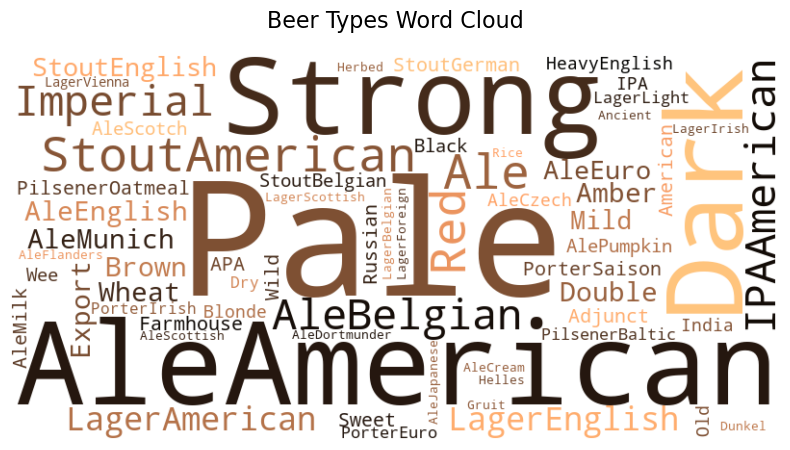

In [4]:
plotting_utils.create_worldcloud(total_reviews)

After these preprocessing steps, we focus on understanding beer preferences among the U.S. reviewers, first by analyzing the number of reviews they left per beer style over the years. What we can notice from the plot is that number of reviews per beer style clearly increases over the years, which is expected due to the growing popularity of internet communities and rating websites in the late 2000s and early 2010s.  

Additionally, if we take a closer look at specific beer styles three types stand out as the most popular for reviewing, particularly **Other Ales**, **IPAs** and **Stouts**. As we already mentioned, Ales have many different subcategories, so it is not suprsining that they are frequently reviewed. Interestingly, Stouts are consistently ranked **third** after 2008, reflecting its stable popularity in the top 3 among beer-reviewing enthusiasts. Another key point is a substantial rise in IPA's reviewers, particularly in the mid-2010s. As we found on the [blog](https://www.beervanablog.com/beervana/2019/12/16/the-2010s-in-review) this period aligns with the time when *IPAs finally became the best-selling style in the craft segment*.

In [5]:
fig = plotting_utils.plot_review_count(total_reviews, year_list)

Continuing on these findings, where IPAs, Other Ales and Stouts emerged as the most-reviewed beer styles, we now shift our focus to understanding which beer styles receive the highest ratings across the United States. For this purpose we use interactive plot of U.S. map where beer styles are groupped by colors and the slider gives an option so see evolutions of these trends over the age range 2004 to 2016.

In [6]:
# Reformat data for plotting
favourite_beers = favourite_beers_processing.FavouriteBeers(results)
data = favourite_beers.favbeer_process_for_mapplotting()
data_plot = plot_state_map.transform_state_abbreviations(data)
data_plot = data_plot.reset_index()

winners_drop = winners[winners.index != 'District Of Columbia']
winners_plot = plot_state_map.transform_state_abbreviations(winners_drop)
winners_plot.sort_values(by='year', ascending=True, inplace=True)
winners_plot = winners_plot.reset_index()

# Initialize the PlotStateMap object with already abbreviated state names
hover_data = {"beer_style": True, "ratings": True, "years": False}
state_map = plot_state_map.PlotStateMap(data_by_state=data_plot, hover_data=hover_data, animation_frame='years', title="Favourite Beer Styles Across U.S. States", state_names_already_abbreviated=True, dataMetric="beer_style")

# Plot the map
fig = state_map.plot_map()

dataframe


**Stouts**, **Porters** and **IPAs** claim the title of nation's favourites. Moreover, after 2010, Stouts dominate as the top-ranked beer style in the majority of states. To further signal a clear preference among reviewers, Stouts claim the top spot in 47 out of 50 states in 2016. Meanwhile, IPAs, though experiencing a surge in popularity in reviewers’ comments during the mid-2010s, don't have a complementary effect on ratings. Interestingly, among the selected beer styles, Lagers appear to be overlooked, never claiming the top spot as a favourite in any state.  

Another interesting point we observed is that some states frequently chose one beer type over the other. To quantify this we analyzed the frequency of selection of beer style as a favourite for each state from 2004 to 2016. Upcoming plot displays chart with dropdown button that allows selection of specific state.  

It can be noticed that some states, such as Kentucky, Massachusetts, Connecticut, Ohio and Oregon show remarkable consistency in their tastes, choosing Stouts as a favourite every single year. On the other hand, states such as Montana, North and South Dakota, Alaska, Utah, Vermont and Wyoming exhibit more diverse tastes, switching between different beer styles as favourites over the years. 

In [7]:
plot = plot_state_map.barplot_fav_styles_per_state(results, data)

Beside numerical ratings, users also left textual reviews. To add another dimension to our analysis, we decided to use [DistilBERT base uncased finetuned SST-2](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english) model to assess sentiment of the textual reviews, i.e. whether it is POSITIVE or NEGATIVE. This approach resulted in another table `reviews2_df.pkl` which contains additional two columns: `sentiment_label` and `sentiment_score` which represent category to which review is classified (either POSITIVE or NEGATIVE) and how confident the model is to its prediction.  

Again, we need to perform some kind of meta-level aggregation on this preference metric. We opted to do the following: for each state, year, beer style combination we counted number of reviews identified to have positive or negative sentiment and then calculated their fraction in total number. To assess this type of beer preference metric we display the upcoming plot.

The plot shows trends in change of fraction of both positive and negative sentiment counts for some subset of states (we will speak more about this subset later, but these are essentially states on which we found election poll results for every election year in time frame 2004-2016).  

The previously observed trend of Lagers not being favoured is reflected here as well, with the fraction of positive reviews for them being substantially lower compared to other beer styles across all states. High fraction of positive reviews (around 80%) for most of the years, beer styles and states reflects general affinity of reviewers to leave positive comments and also high ratings.

Potentially, with more broader emotional sentiment analysis we could've captured somewhat different results, however that would've increased the dimensionality of our already high-dimensional problem and make analysis more complex so we stayed with this choice.

In [11]:
# Loading and filtering sentiments
sentiment_path = str(beer_advocate_path / "reviews2_df.pkl")

sentiment_reviews = reviews_processing.Reviews(users_path, sentiment_path)
per_sentiment = sentiment_reviews.posneg_sentiment_aggregation_counts(all_states=False)
per_sentiment_filt = per_sentiment[per_sentiment['year'].isin(year_list)]

fig_years = plotting_utils.plot_sentiment_posneg_states(per_sentiment_filt)

## Dive into Politics 

Now that we have identified the most popular beer styles across U.S. states, we can explore whether we can link the taste buds of these beer drinkers to their political affiliation. Specifically, we will examine the U.S. states during four key election years: 2004, 2008, 2012, and 2016 - which already led to our analysis being narrowed down to time range from 2004 to 2016. To begin, we will determine which political party won each state in these elections. To do so we provie a plot showing Election Winners across U.S. states, where Red represent Republican and Blue Democrat states.  

As we can see some states remained consistent in their political leanings over the years, with the same party winning across all four elections. For example, California, New York, and Massachusetts are consistently Democrat, while Texas, Arizona, and Montana have consistently leaned Republican. On the other hand, states that shift their political affiliations between elections, i.e. **swing states**, are particularly interesting to analyze, as they often play a decisive role in determining the outcome of the elections. Some examples are Pennsylvania, Nevada, Virginia and Indiana. In the rest of the analysis we will mention other too. 

In [12]:
# Plot winning parties
hover_data = {"winner": True, "state": True, "year": False}

state_map = plot_state_map.PlotStateMap(data_by_state=winners_plot, hover_data=hover_data, animation_frame='year', title="Election Winners Across U.S. States", state_names_already_abbreviated=True, dataMetric="winner")

# Plot the map
fig1 = state_map.plot_map()

dataframe


## Clustering of Voting Trends with Look-alike Analysis  

Now, let's dive into the most interesting part of our analysis - understanding whether political leaning influences beer preferences!

In our analysis, it is important to consider **confounding factors** that could influence both political affiliation and the beer preference.  

Key factors to consider include:
* age, 
* wealth (i.e., economic status), 
* education level, 
* ethnicity, and others.  

However, these factors are *tricky* to determine for each specific user.  
 
Extracting details like educational background from their beer review text is challenging and one would argue that even the greatest writers in history might not produce the most eloquent or inspiring beer reviews. We even tried approaching the problem of unknown age with a proxy - assuming that each user was at least 21 years old when leaving the review and calculating the age as `21 + years(date_user_joining - date_review_left)`. However, this left us with extremely skewed distribution with users 'being able to age' only between 21 and 37 (if they were loyal reviewers from 2001 to 2017).  

Additionally, only information about political leanings that we had was on the level of state.

Therefore, we decided to conduct our analysis at the **state level**. What this means is that we will aggregate beer preferences (average rating and fraction of positive sentiment) on the state level (which we already explained how it was achieved in the first section) and use it as a proxy for a state-level beer preference.  

In our state-level analysis, we will focus on two main cofounding factors: *age* and *geographical location*. As explained, extracting age information wasn't feasible, therefore we opted to outsource this demographic data. We make an *assumption* that the beer drinkers and reviewers on the website have a uniformly distributed age in range between 18 and 64. Other potential factors, such as ethnicity or income per capita, were excluded to avoid additional complexity and the difficulty of analysing their mutual impact on each other.

The age data linked to voting patterns was obtained from **exit polls** for the election years: [2004](https://www.nytimes.com/elections/2012/results/president/exit-polls.html), [2008](https://archive.nytimes.com/www.nytimes.com/elections/2008/results/president/national-exit-polls.html?mod=article_inline), [2012](https://www.nytimes.com/elections/2012/results/president/exit-polls.html), and [2016](https://edition.cnn.com/election/2016/results/exit-polls) with age groups categorized as 18-29, 30-44, and 45-64. This data provides the percentage of Democrat and Republican votes for each age group across 17 states, since exit poll data was not available for all states due to poll not being conducted, as previously mentioned. States we are left with are: Arizona, California, Florida, Georgia, Indiana, Iowa, Kentucky, Nevada, New York, New Hampshire, North Carolina, Pennsylvania, South Carolina, Texas, Virginia, Wisconsin.

Since we have more fine-grained information about beer reviews, and therefore beer preferences for each state, which can be grouped at the year level or even the 6-month level, we decided to **interpolate** the voting data to cover *each year*. To achieve this, we applied linear interpolation for the years between election ones. The results are illustrated in the following plot which displays Vote Distribution for Democrats and Republicans by State, Age Group and Year.

In [17]:
# Interpolate voting data
age_groups = ["18_29", "30_44", "45_64"]
voting_data_merged = corr.merge_voting_by_years(project_dir)
interpolate_data = corr.interpolate_votes(voting_data_merged)

interpolated_data_reshaped = corr.reshape_data(interpolate_data, year_list, age_groups)
plot_state_map.plot_vote_distribution(interpolated_data_reshaped, age_groups)

Some interesting observations:
* In New York, young voters (aged 18-29) consistently favour Democrats over Republicans. 
* On top of that young voters are usually the ones voting the most for Democrat party even in more Republican-leaning states. However, those percentages are smaller compared to Democrat states. For example, the percentage of young Democrat voters in New York (a Democrat state) is consistently higher than in Texas (a Republican state). 
* Interestingly, for the oldest age group in Arizona (a Republican state), the ratio of Democrat to Republican voters remains relatively stable over the years, whereas the other two age groups show more dynamic changes.

*PRETPOSTAVLJAM DA OVDE IDE MALO DETALJNIJA PRICA O KLASTEROVANJU*

Given the scale of the data, spanning 13 years and 17 states, it is challenging to draw conclusions about political trends, changes over time and similarities between states.  

To address this and perform look-alike type of the analysis, we opt for an unsupervised approach to group states and identify patterns in the data. Specifically, we apply **K-Means clustering** to this time-series data - percentage of democrat votes for each age group, in the span of 13 years. The number of clusters is set to **3**, based on the assumption that they represent *consistently Democrat states*, *consistently Republican states*, and *swing states*.  

The resulting clusters are shown below. PCA decomposition is used to represent high-dimensional time series in 2 dimensions.


In [19]:
# Drop all columns containing 'republican' in their names since they don't add more information 
interpolate_data_filt = interpolate_data.loc[:, ~interpolate_data.columns.str.contains('republican')]

# Apply K-Means 
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(interpolate_data_filt)
states = interpolate_data_filt.index
kmeans_labels = kmeans.labels_
state_clusters = dict(zip(states, kmeans_labels))

# Visualization of clustering on a lower dimension
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(interpolate_data_filt)

fig = plotting_utils.plot_clustering(reduced_data[:, 0], reduced_data[:, 1], kmeans_labels, states)

We observe some interesting results.  

On the far right, funnily enough, we see New York and California - two consistently Democratic states known for their progressive policies and strong liberal voting history. On the left, clustered together are Texas, Arizona, Georgia, Kentucky and South Carolina, which are Republican states, known for their strong conservative values. Indiana, a swing state (which had Republicans win on three ocasions in 2004, 2012 and 2016), is also part of this cluster. In the middle we observe a cluster of swing states, with an exception of New Hampshire, which is a Democrat state. 

 Therefore, we will consider that these clusters represent Democrat, Republican and swing state groups of states that have *similar voting trends*, i.e. **look-alike states**.

## Comparison of Beer Preferences Trends between Look-alike States